# 本程序用于分析往届《结构力学（2）》的成绩

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt


path = "./"
files = os.listdir(path)

定义读入文件生成 DataFrame 的函数

In [2]:
# 定义读入单个文件生成 DataFrame 的函数
def readFile(fileName):
    df = pd.read_csv(fileName, sep="\t")
    return df


# 定义读入全部文件生成 DataFrame 的函数
def readFiles(files):
    df = pd.DataFrame()
    for file in files:
        # 判断文件是否以 .txt 结尾
        if file.endswith(".txt"):
            df = pd.concat([df, readFile(file)])
    return df

In [3]:
# 输入1：读入指定文件名的文件，输入2：读入全部文件，输入其他内容退出程序
def main():
    print("可选择的文件名包括:")
    readFileNames = [file.split(".")[0] for file in files if file.endswith(".txt")]
    for fileName in readFileNames:
        print(fileName)
    print("输入1：读入指定文件名的文件，输入2：读入全部文件，输入其他内容退出程序")
    choice = input()
    if choice == "1":
        fileName = input("请输入文件名：") + ".txt"
        df = readFile(fileName)
    elif choice == "2":
        df = readFiles(files)
    else:
        exit()
    return df

In [4]:
df = main()

可选择的文件名包括:
19201
18191
22231
24251
23241
20211
21221
输入1：读入指定文件名的文件，输入2：读入全部文件，输入其他内容退出程序


In [5]:
# 重新生成 index 从 0 开始
df = df.reset_index(drop=True)
len1 = len(df)
# 清洗数据
# 去除”期末成绩“不是数字的行
df = df[pd.to_numeric(df["期末成绩"], errors="coerce").notnull()]
# 将”期末成绩“、”平时成绩“、”最终成绩“转换为数值型
df["期末成绩"] = pd.to_numeric(df["期末成绩"], errors="coerce")
df["平时成绩"] = pd.to_numeric(df["平时成绩"], errors="coerce")
df["最终成绩"] = pd.to_numeric(df["最终成绩"], errors="coerce")
len2 = len(df)
print(f"初始数据一共有 {len1} 条，清洗后一共有 {len2} 条数据")

初始数据一共有 771 条，清洗后一共有 766 条数据


In [6]:
# 当前有效成绩总数
print(f"当前有效成绩共 {len2} 条记录")
# 列出平时成绩平均值和标准差，列出总评成绩平均值和标准差，列出最终成绩平均值和标准差
print(
    f"平时成绩：平均值 = {df["平时成绩"].mean():.2f}, 标准差 = {df["平时成绩"].std():.2f}"
)
print(
    f"期末成绩：平均值 = {df["期末成绩"].mean():.2f}, 标准差 = {df["期末成绩"].std():.2f}"
)
print(
    f"最终成绩：平均值 = {df["最终成绩"].mean():.2f}, 标准差 = {df["最终成绩"].std():.2f}"
)

当前有效成绩共 766 条记录
平时成绩：平均值 = 82.69, 标准差 = 14.69
期末成绩：平均值 = 75.58, 标准差 = 17.12
最终成绩：平均值 = 77.76, 标准差 = 15.64


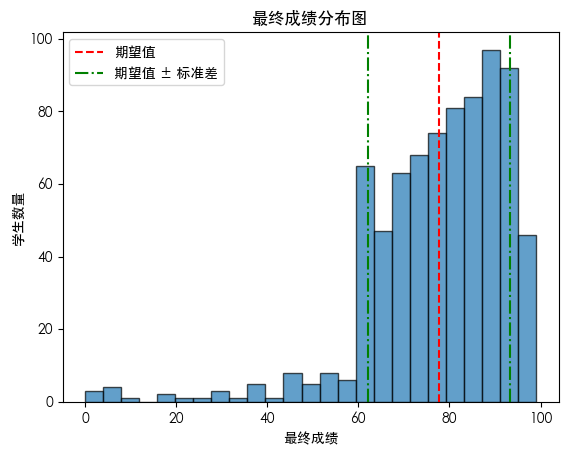

In [7]:
# 绘制最终成绩直方图，显示均值、方差、标准差
plt.rcParams["font.sans-serif"] = ["STHeiti"]  # 用来正常显示中文标签
plt.hist(df["最终成绩"], bins=25, edgecolor="black", histtype="bar", alpha=0.7)
plt.xlabel("最终成绩")
plt.ylabel("学生数量")
plt.title("最终成绩分布图")
plt.axvline(df["最终成绩"].mean(), color="red", linestyle="--", label="期望值")
plt.axvline(
    df["最终成绩"].mean() + df["最终成绩"].std(),
    color="green",
    linestyle="-.",
    label="期望值 ± 标准差",
)
plt.axvline(df["最终成绩"].mean() - df["最终成绩"].std(), color="green", linestyle="-.")
plt.legend()
plt.show()

模型评价结果:
        模型  R-squared        MSE      MAE
    线性回归   0.608568 100.885651 7.384495
  多项式回归   0.611790 100.055312 7.388076
  决策树回归   0.556718 114.249238 7.469220
支持向量回归   0.513736 125.327332 6.438897


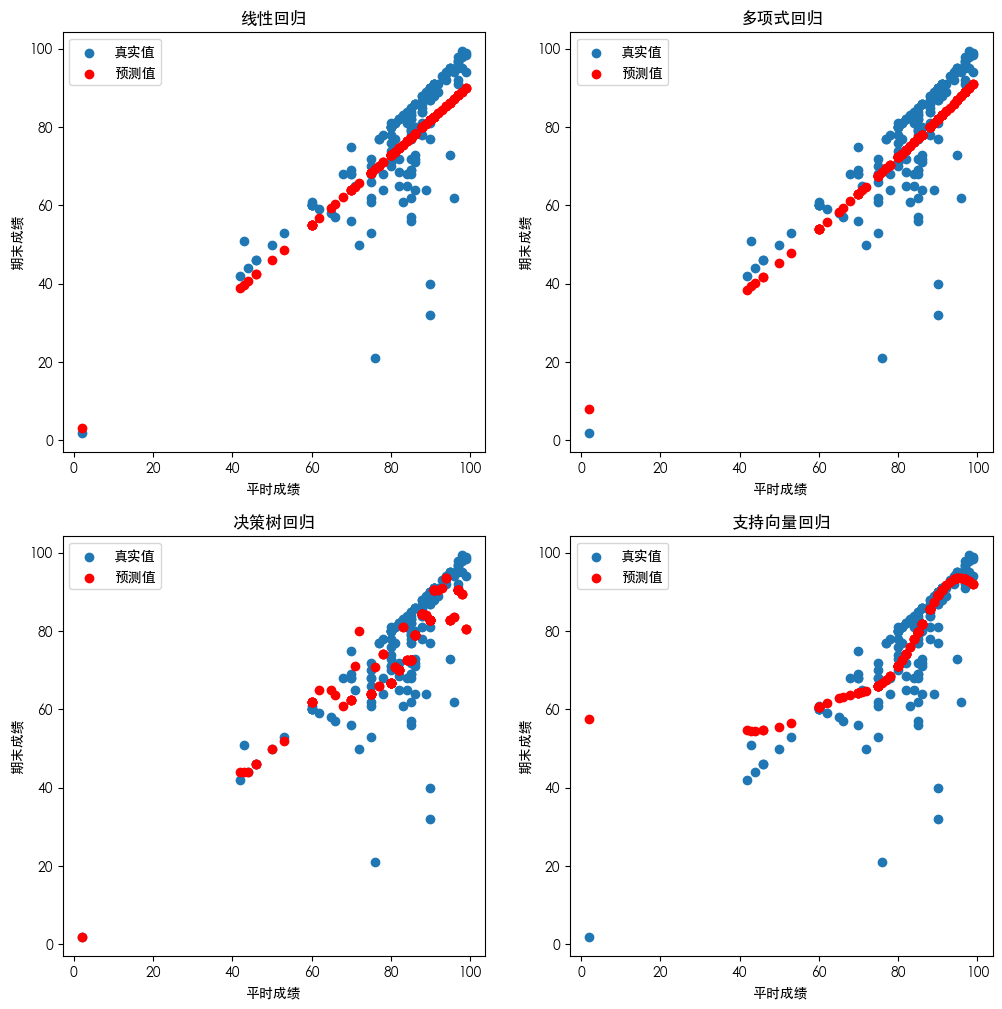

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 特征和目标变量
X = df[["平时成绩"]]
y = df["期末成绩"]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888)


# 线性回归
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# 多项式回归
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
lr_poly = LinearRegression()
lr_poly.fit(X_poly, y_train)
y_pred_poly = lr_poly.predict(poly.fit_transform(X_test))

# 决策树回归
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

# 支持向量回归
svr = SVR()
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

# 在一个DataFrame中存储所有模型的评价结果并打印
evaluations = pd.DataFrame(
    {
        "模型": ["线性回归", "多项式回归", "决策树回归", "支持向量回归"],
        "R-squared": [
            r2_score(y_test, y_pred),
            r2_score(y_test, y_pred_poly),
            r2_score(y_test, y_pred_tree),
            r2_score(y_test, y_pred_svr),
        ],
        "MSE": [
            mean_squared_error(y_test, y_pred),
            mean_squared_error(y_test, y_pred_poly),
            mean_squared_error(y_test, y_pred_tree),
            mean_squared_error(y_test, y_pred_svr),
        ],
        "MAE": [
            mean_absolute_error(y_test, y_pred),
            mean_absolute_error(y_test, y_pred_poly),
            mean_absolute_error(y_test, y_pred_tree),
            mean_absolute_error(y_test, y_pred_svr),
        ],
    }
)

# 打印时每列数据左对齐
pd.set_option("display.unicode.ambiguous_as_wide", True)
pd.set_option("display.unicode.east_asian_width", True)
pd.set_option("display.width", 200)
print(f"模型评价结果:\n{evaluations.to_string(index=False)}")

# 画四个子图，每个子图用散点图表示一种回归模型预测平时成绩和期末成绩的关系
plt.rcParams["font.sans-serif"] = ["STHeiti"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
# 第一个子图用散点图表示线性回归预测结果
axes[0, 0].scatter(X_test, y_test, label="真实值")
axes[0, 0].scatter(X_test, y_pred, label="预测值", color="red")
axes[0, 0].set_title("线性回归")
axes[0, 0].set_xlabel("平时成绩")
axes[0, 0].set_ylabel("期末成绩")
axes[0, 0].legend()
# 第二个子图用散点图表示多项式回归预测结果
axes[0, 1].scatter(X_test, y_test, label="真实值")
axes[0, 1].scatter(X_test, y_pred_poly, label="预测值", color="red")
axes[0, 1].set_title("多项式回归")
axes[0, 1].set_xlabel("平时成绩")
axes[0, 1].set_ylabel("期末成绩")
axes[0, 1].legend()
# 第三个子图用散点图表示决策树回归预测结果
axes[1, 0].scatter(X_test, y_test, label="真实值")
axes[1, 0].scatter(X_test, y_pred_tree, label="预测值", color="red")
axes[1, 0].set_title("决策树回归")
axes[1, 0].set_xlabel("平时成绩")
axes[1, 0].set_ylabel("期末成绩")
axes[1, 0].legend()
# 第四个子图用散点图表示支持向量回归预测结果
axes[1, 1].scatter(X_test, y_test, label="真实值")
axes[1, 1].scatter(X_test, y_pred_svr, label="预测值", color="red")
axes[1, 1].set_title("支持向量回归")
axes[1, 1].set_xlabel("平时成绩")
axes[1, 1].set_ylabel("期末成绩")
axes[1, 1].legend()
plt.show()